Epoch 1/100
13/13 [==============================] - 71s 4s/step - loss: 0.0835 - accuracy: 0.9534 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 2/100
13/13 [==============================] - 45s 3s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/100
13/13 [==============================] - 45s 3s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.9723e-04 - val_accuracy: 1.0000
Epoch 4/100
13/13 [==============================] - 42s 3s/step - loss: 8.6529e-04 - accuracy: 1.0000 - val_loss: 4.1324e-04 - val_accuracy: 1.0000
Epoch 5/100
13/13 [==============================] - 43s 3s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.0468e-04 - val_accuracy: 1.0000
Epoch 6/100
13/13 [==============================] - 43s 3s/step - loss: 6.7220e-04 - accuracy: 1.0000 - val_loss: 9.2021e-05 - val_accuracy: 1.0000
Epoch 7/100
13/13 [==============================] - 43s 3s/step - loss: 4.7225e-04 - accuracy: 1.0000 - val_loss: 8.6948e-05 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 7s 2s/step - loss: 8.2288e-07 - accuracy: 1.0000
NASNet Test Loss: 8.228837486967677e-07
NASNet Test Accuracy: 1.0
4/4 [==============================] - 11s 1s/step
NASNet Accuracy: 1.0
NASNet Confusion Matrix:
 [[49  0]
 [ 0 53]]
NASNet Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        49
         1.0       1.00      1.00      1.00        53

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



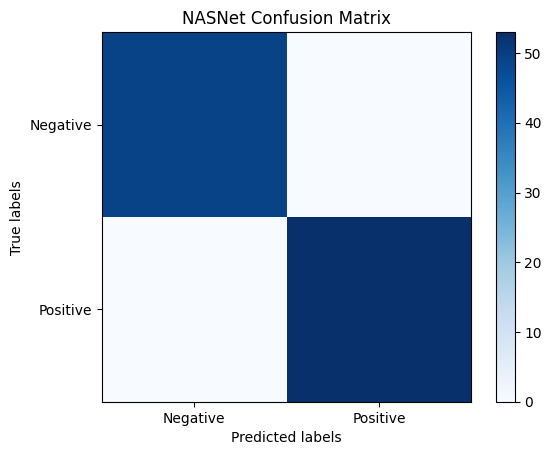

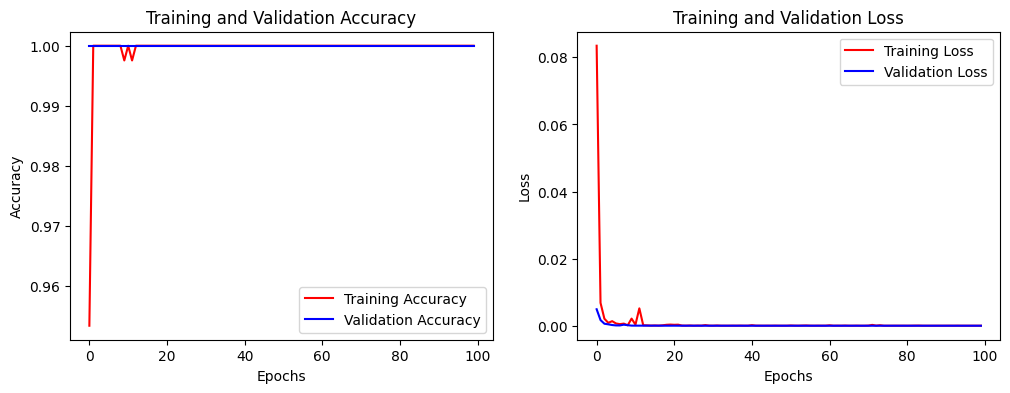

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# Load data from positive and negative directories
def load_data_from_directories(pos_directory, neg_directory, img_size=(224, 224)):
    positive_images = []
    negative_images = []

    # Load positive images
    for filename in os.listdir(pos_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(pos_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image to 224x224 for NASNet
            positive_images.append(img)

    # Load negative images
    for filename in os.listdir(neg_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(neg_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image to 224x224 for NASNet
            negative_images.append(img)

    return np.array(positive_images), np.array(negative_images)

# Directories containing positive and negative images
positive_directory = '/content/drive/MyDrive/positive lake training'
negative_directory = '/content/drive/MyDrive/negative lake training'

# Load data
positive_images, negative_images = load_data_from_directories(positive_directory, negative_directory)

# Create labels
positive_labels = np.ones(len(positive_images))
negative_labels = np.zeros(len(negative_images))

# Combine images and labels
X = np.concatenate((positive_images, negative_images), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define NASNet model
def create_nasnet_model(input_shape):
    base_model = tf.keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create NASNet model
input_shape = X_train[0].shape
nasnet_model = create_nasnet_model(input_shape)

# Compile the NASNet model
nasnet_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# Use data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the NASNet model and store history
nasnet_history = nasnet_model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=100
)

# Save training history to CSV
history_df = pd.DataFrame(nasnet_history.history)
history_df.to_csv('/content/drive/MyDrive/nasnet_training_history_rmsprop.csv', index=False)

# Save the model
nasnet_model.save('/content/drive/MyDrive/nasnet_model_rmsprop.h5')

# Evaluate the NASNet model
nasnet_test_loss, nasnet_test_accuracy = nasnet_model.evaluate(X_test, y_test)

print("NASNet Test Loss:", nasnet_test_loss)
print("NASNet Test Accuracy:", nasnet_test_accuracy)

# Generate predictions
nasnet_y_pred_probs = nasnet_model.predict(X_test)
nasnet_y_pred = (nasnet_y_pred_probs > 0.5).astype(int)

# Calculate accuracy
nasnet_accuracy = accuracy_score(y_test, nasnet_y_pred)
print("NASNet Accuracy:", nasnet_accuracy)

# Calculate confusion matrix
nasnet_confusion_mat = confusion_matrix(y_test, nasnet_y_pred)
print("NASNet Confusion Matrix:\n", nasnet_confusion_mat)

# Generate classification report
nasnet_class_report = classification_report(y_test, nasnet_y_pred)
print("NASNet Classification Report:\n", nasnet_class_report)

# Plot confusion matrix
plt.imshow(nasnet_confusion_mat, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.title('NASNet Confusion Matrix')
plt.show()

# Plot training & validation loss and accuracy
def plot_training_history(history_df):
    # Extract the data from the history DataFrame
    acc = history_df['accuracy']
    val_acc = history_df['val_accuracy']
    loss = history_df['loss']
    val_loss = history_df['val_loss']

    epochs = range(len(acc))

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_df)


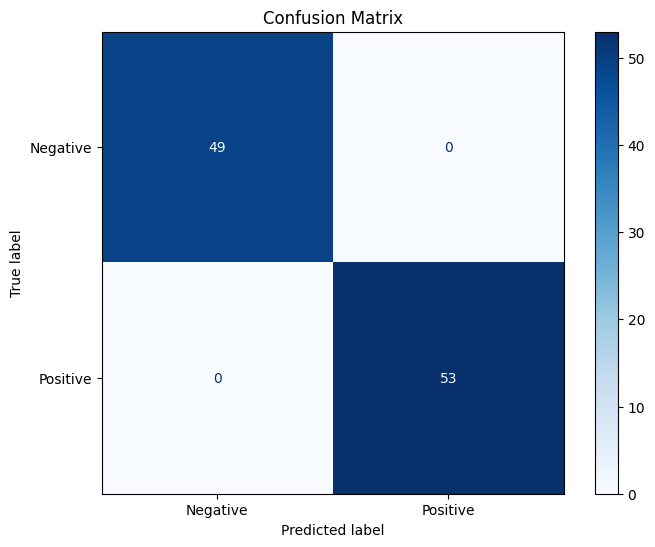

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Define the confusion matrix
confusion_matrix = np.array([[49, 0], [0, 53]])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive'])

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.show()